In [2]:
import os 
print(os.getcwd())


/kaggle/working


False

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import os

# Define data directories
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

# Set image parameters
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
EPOCHS = 12

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Build the model using Transfer Learning (VGG16)
base_model = VGG16(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False


# Add custom classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy','recall']
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE
)



Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 408ms/step - accuracy: 0.8610 - loss: 0.3148 - recall: 0.9532 - val_accuracy: 0.8750 - val_loss: 0.2809 - val_recall: 1.0000
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 399ms/step - accuracy: 0.9350 - loss: 0.1691 - recall: 0.9537 - val_accuracy: 0.7500 - val_loss: 0.6239 - val_recall: 1.0000
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 400ms/step - accuracy: 0.9456 - loss: 0.1351 - recall: 0.9653 - val_accuracy: 0.8750 - val_loss: 0.2408 - val_recall: 1.0000
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 397ms/step - accuracy: 0.9514 - loss: 0.1261 - recall: 0.9638 - val_accuracy: 0.8750 - val_loss: 0.3238 - val_recall: 1.0000
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 398ms/step - accuracy: 0.9596 - loss: 0.1107 - recall: 0.9734 - val_accuracy: 0.8750 - val_loss: 0.1949 - val_recall: 1.0000
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 397ms/step - accuracy: 0.9480 - loss: 0.1258 - recall: 0.9662 - val_accuracy: 0.8750 - val_loss: 0.2542 - val_r

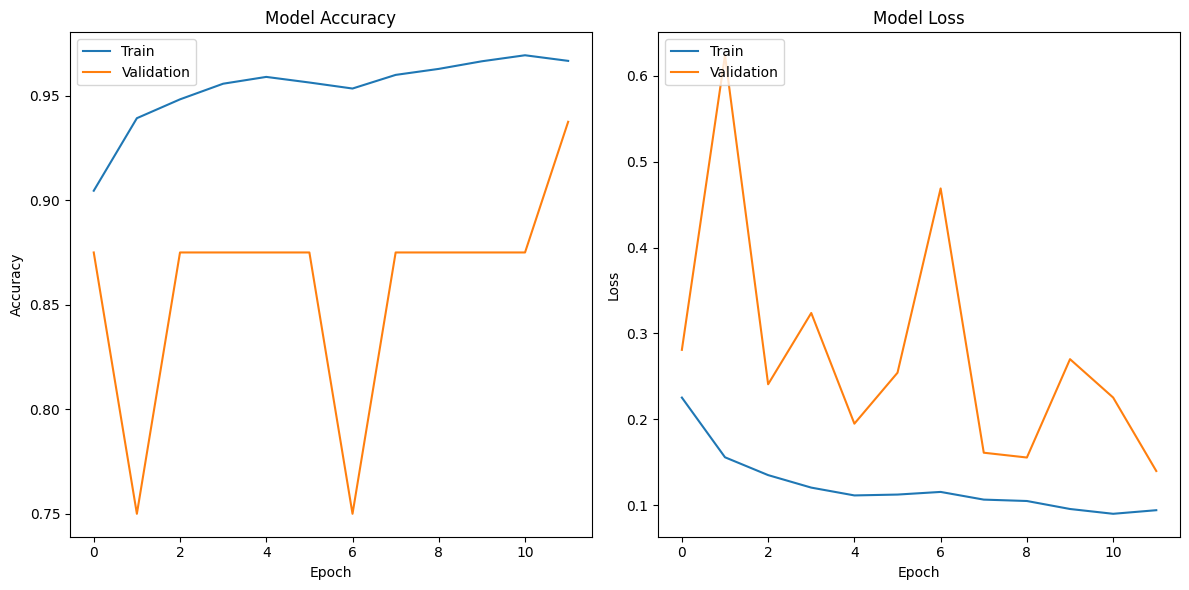

In [19]:
#
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load the test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1, # Use a batch size of 1 for evaluation
    class_mode='binary',
    shuffle=False # Do not shuffle the test data
)

# Predict probabilities on the test data
print("Evaluating model...")
Y_pred_proba = model.predict(test_generator, steps=test_generator.samples, verbose=1)

# Get true labels from the generator
Y_true = test_generator.classes

# Convert probabilities to binary class labels (0 or 1)
# The threshold is 0.5 for the sigmoid activation
Y_pred = (Y_pred_proba > 0.5).astype(int)

# Generate and print the confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
print("\nConfusion Matrix:")
print(cm)

# Generate and print the classification report
report = classification_report(Y_true, Y_pred, target_names=['Normal', 'Pneumonia'])
print("\nClassification Report:")
print(report)

print("\nEvaluation complete.")

Found 624 images belonging to 2 classes.
Evaluating model...
624/624 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step

Confusion Matrix:
[[170  64]
 [  5 385]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.73      0.83       234
   Pneumonia       0.86      0.99      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.86      0.87       624
weighted avg       0.90      0.89      0.89       624


Evaluation complete.


In [24]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Define image size
img_height, img_width = 150, 150

# Path to the single image you want to predict
img_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg'

# Load the image and resize it
img = image.load_img(img_path, target_size=(img_height, img_width))
# print(img)

# Convert the image to a NumPy array
img_array = image.img_to_array(img)

# Expand dimensions to create a batch of size 1
# The model expects a batch of images, even if it's just one.
img_array = np.expand_dims(img_array, axis=0)

# Normalize the pixel values (scale from 0-255 to 0-1)
img_array = img_array / 255.0


# Load the pre-trained model
# model = tf.keras.models.load_model('pneumonia_classifier_model.h5')

# Get the prediction
prediction = model.predict(img_array)

# The output is a probability. The closer to 1, the more likely it's 'Pneumonia'.
# The closer to 0, the more likely it's 'Normal'.
print(f"Prediction probability: {prediction[0][0]:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction probability: 0.0406


In [23]:
# Save the trained model
model.save('pneumonia_classifier_model.h5')
print("Model saved as pneumonia_classifier_model.h5")

Model saved as pneumonia_classifier_model.h5


In [25]:
#predict the single image
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model only once
# @tf.function can also be used here for performance
model = tf.keras.models.load_model('pneumonia_classifier_model.h5')

# Define the image dimensions used for training
IMG_HEIGHT, IMG_WIDTH = 150, 150

def predict_single_image(img_path):
    """
    Loads, preprocesses, and predicts the class of a single image.

    Args:
        img_path (str): The file path to the image.

    Returns:
        tuple: A tuple containing the predicted class (str) and confidence (float).
    """
    try:
        # Load the image and resize it to the target dimensions
        img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

        # Convert the image to a NumPy array
        img_array = image.img_to_array(img)

        # Expand dimensions to create a batch of size 1
        img_array = np.expand_dims(img_array, axis=0)

        # Normalize the pixel values to the 0-1 range
        img_array = img_array / 255.0

        # Make a prediction
        prediction = model.predict(img_array)[0][0]

        # Determine the class based on the prediction threshold
        if prediction > 0.5:
            predicted_class = "Pneumonia"
            confidence = prediction * 100
        else:
            predicted_class = "Normal"
            confidence = (1 - prediction) * 100

        return predicted_class, confidence

    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None

# Example usage:
# prediction, confidence = predict_single_image('path/to/your/image.jpg')
# if prediction:
#     print(f"Prediction: {prediction}, Confidence: {confidence:.2f}%")